# RECIPE RECOMMENDATION CODES

## Loading Dataset

In [2]:
# Import necessary libraries
import pandas as pd
import json

# Load Recipe1M+ Dataset
recipe1m = pd.read_csv('datasets/full_dataset.csv')

# Load Food.com Recipes and User Interactions
pp_recipes = pd.read_csv('datasets/PP_recipes.csv')  
pp_users = pd.read_csv('datasets/PP_users.csv')
raw_interactions = pd.read_csv('datasets/RAW_interactions.csv')
raw_recipes = pd.read_csv('datasets/RAW_recipes.csv')

# Load What's Cooking Dataset (JSON format)
with open('datasets/train.json') as f:
    whats_cooking_train = json.load(f)
whats_cooking_train = pd.DataFrame(whats_cooking_train)

with open('datasets/test.json') as f:
    whats_cooking_test = json.load(f)
whats_cooking_test = pd.DataFrame(whats_cooking_test)

## EDA and data cleaning

In [3]:
# Display the first few rows of each dataset
print("Recipe1M+ Dataset:")
print(recipe1m.head())
print("\nFood.com RAW_interactions:")
print(raw_interactions.head())
print("\nFood.com RAW_recipes:")
print(raw_recipes.head())
print("\nWhat's Cooking Train:")
print(whats_cooking_train.head())

# Check for missing values
print("Missing values in Recipe1M+ Dataset:", recipe1m.isnull().sum())
print("Missing values in Food.com RAW_interactions:", raw_interactions.isnull().sum())
print("Missing values in Food.com RAW_recipes:", raw_recipes.isnull().sum())
print("Missing values in What's Cooking Train:", whats_cooking_train.isnull().sum())

# Handle missing values
recipe1m.dropna(inplace=True)
raw_interactions.dropna(inplace=True)
raw_recipes.dropna(inplace=True)
whats_cooking_train.dropna(inplace=True)

# Convert lists to strings for ingredients in whats_cooking_train before removing duplicates
whats_cooking_train['ingredients'] = whats_cooking_train['ingredients'].apply(lambda x: ','.join(x) if isinstance(x, list) else x)

# Remove duplicates
recipe1m.drop_duplicates(inplace=True)
raw_interactions.drop_duplicates(inplace=True)
raw_recipes.drop_duplicates(inplace=True)
whats_cooking_train.drop_duplicates(inplace=True)

# Normalize text
def normalize_text(df, column):
    df[column] = df[column].str.lower().str.replace(r'[^\w\s]', '')
    return df

recipe1m = normalize_text(recipe1m, 'ingredients')
recipe1m = normalize_text(recipe1m, 'title')

raw_recipes = normalize_text(raw_recipes, 'ingredients')
raw_recipes = normalize_text(raw_recipes, 'name')
raw_recipes = raw_recipes.rename(columns={'name': 'title', 'steps': 'directions'})

whats_cooking_train = normalize_text(whats_cooking_train, 'ingredients')
whats_cooking_train = whats_cooking_train.rename(columns={'id': 'title', 'cuisine': 'directions'})

# Feature Engineering (e.g., ingredient count)
def extract_features(df):
    df['ingredient_count'] = df['ingredients'].apply(lambda x: len(x.split(',')))
    return df

recipe1m = extract_features(recipe1m)
raw_recipes = extract_features(raw_recipes)
whats_cooking_train = extract_features(whats_cooking_train)

# Combine datasets if necessary
combined_recipes = pd.concat([recipe1m[['title', 'ingredients', 'directions']],
                              raw_recipes[['title', 'ingredients', 'directions']],
                              whats_cooking_train[['title', 'ingredients', 'directions']]], ignore_index=True)
combined_recipes.drop_duplicates(inplace=True)

# Verify the combined dataset
print(combined_recipes.head())


Recipe1M+ Dataset:
   Unnamed: 0                  title  \
0           0    No-Bake Nut Cookies   
1           1  Jewell Ball'S Chicken   
2           2            Creamy Corn   
3           3          Chicken Funny   
4           4   Reeses Cups(Candy)     

                                         ingredients  \
0  ["1 c. firmly packed brown sugar", "1/2 c. eva...   
1  ["1 small jar chipped beef, cut up", "4 boned ...   
2  ["2 (16 oz.) pkg. frozen corn", "1 (8 oz.) pkg...   
3  ["1 large whole chicken", "2 (10 1/2 oz.) cans...   
4  ["1 c. peanut butter", "3/4 c. graham cracker ...   

                                          directions  \
0  ["In a heavy 2-quart saucepan, mix brown sugar...   
1  ["Place chipped beef on bottom of baking dish....   
2  ["In a slow cooker, combine all ingredients. C...   
3  ["Boil and debone chicken.", "Put bite size pi...   
4  ["Combine first four ingredients and press in ...   

                                              link    source  \
0 

## Feature Engineering

In [4]:
def extract_features(df):
    df['ingredient_count'] = df['ingredients'].apply(lambda x: len(x.split(',')))
    return df
recipe1m = extract_features(recipe1m)
raw_recipes = extract_features(raw_recipes)
whats_cooking_train = extract_features(whats_cooking_train)

# combined recipes
combined_recipes = pd.concat([recipe1m[['title', 'ingredients', 'directions']],
                              raw_recipes[['title', 'ingredients', 'directions']],
                              whats_cooking_train[['title', 'ingredients', 'directions']]], ignore_index=True)
combined_recipes.drop_duplicates(inplace=True)
print(combined_recipes.head())

                   title                                        ingredients  \
0    no-bake nut cookies  ["1 c. firmly packed brown sugar", "1/2 c. eva...   
1  jewell ball's chicken  ["1 small jar chipped beef, cut up", "4 boned ...   
2            creamy corn  ["2 (16 oz.) pkg. frozen corn", "1 (8 oz.) pkg...   
3          chicken funny  ["1 large whole chicken", "2 (10 1/2 oz.) cans...   
4   reeses cups(candy)    ["1 c. peanut butter", "3/4 c. graham cracker ...   

                                          directions  
0  ["In a heavy 2-quart saucepan, mix brown sugar...  
1  ["Place chipped beef on bottom of baking dish....  
2  ["In a slow cooker, combine all ingredients. C...  
3  ["Boil and debone chicken.", "Put bite size pi...  
4  ["Combine first four ingredients and press in ...  


## Content-Based Filtering and Recommendation

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Content-Based Filtering
def content_based_recommendation(df, user_preferences):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(df['ingredients'])
    user_tfidf = vectorizer.transform([', '.join(user_preferences['available_ingredients'])])
    
    cosine_sim = cosine_similarity(user_tfidf, tfidf_matrix).flatten()
    recommended_indices = cosine_sim.argsort()[-5:][::-1]
    return df.iloc[recommended_indices]

# Hybrid Recommendation
def hybrid_recommendation(user_preferences, recipes_df):
    content_recommendations = content_based_recommendation(recipes_df, user_preferences)
    return content_recommendations.head(5)


## User Input and Recipes Recommendation according to user preferences
input user preferences and generate personalized recommendations.

In [7]:
def get_user_preferences():
    dietary_restrictions = input("Enter dietary restrictions (comma-separated): ").split(',')
    cuisine_preferences = input("Enter cuisine preferences (comma-separated): ").split(',')
    available_ingredients = input("Enter available ingredients (comma-separated): ").split(',')
    time_to_cook = int(input("Enter time to cook (in minutes): "))

    user_preferences = {
        'dietary_restrictions': dietary_restrictions,
        'cuisine_preferences': cuisine_preferences,
        'available_ingredients': available_ingredients,
        'time_to_cook': time_to_cook
    }
    return user_preferences

user_preferences = get_user_preferences()

# generate recommendations based on input
recommended_recipes = hybrid_recommendation(user_preferences, combined_recipes)

# Display recommendations
for idx, recipe in recommended_recipes.iterrows():
    print(f"Title: {recipe['title']}")
    print(f"Ingredients: {recipe['ingredients']}")
    print(f"Directions: {recipe['directions']}\n")
    print("_______________________________________\n")


Title: oil-free non-fried potato chips
Ingredients: ["1 potato", "1 salt"]
Directions: ["Peel and slice the potato.", "You don't have to slice it super thin, 1 mm or so is about right.", "You can do this quickly using a vegetable slice.", "Line the turntable of your microwave with kitchen parchment paper, and place the potato slices on it so that they don't overlap.", "Sprinkle lightly with salt, and microwave for about 5-6 minutes at 600 W. They will burn if you cook them too long, so keep an eye on them and adjust the time.", "If they look crispy, they are done.", "Variations: Besides salt, try seasoning the chips with aonori seaweed and salt; mentsuyu; Krazy Salt; garlic salt; soup stock granules; paprika or curry powder, karaage powder, etc.", "Try with other vegetables besides potatoes too."]

_______________________________________

Title: farm fresh baked potato chips
Ingredients: ['potato', 'salt']
Directions: ['preheat oven to 300', 'oil 2 large baking sheets with veg oil', 's

In [8]:
def get_user_preferences():
    print("Please answer the following questions to provide your preferences:")
    dietary_restrictions = input("Enter dietary restrictions (comma-separated): ").split(',')
    cuisine_preferences = input("Enter cuisine preferences (comma-separated): ").split(',')
    available_ingredients = input("Enter available ingredients (comma-separated): ").split(',')
    time_to_cook = int(input("Enter time to cook (in minutes): "))

    user_preferences = {
        'dietary_restrictions': dietary_restrictions,
        'cuisine_preferences': cuisine_preferences,
        'available_ingredients': available_ingredients,
        'time_to_cook': time_to_cook
    }
    print("\nUser Preferences:")
    for key, value in user_preferences.items():
        print(f"{key}: {', '.join(map(str, value)) if isinstance(value, list) else value}")
    return user_preferences

user_preferences = get_user_preferences()

# Generate recommendations based on input
recommended_recipes = hybrid_recommendation(user_preferences, combined_recipes)

# Display recommendations
print("\nRecommended Recipes:\n")
for idx, recipe in recommended_recipes.iterrows():
    print(f"Title: {recipe['title']}")
    print(f"Ingredients: {recipe['ingredients']}")
    print(f"Directions: {recipe['directions']}\n")
    print("_______________________________________\n")


Please answer the following questions to provide your preferences:

User Preferences:
dietary_restrictions: 
cuisine_preferences: Italian
available_ingredients: tomato, noodles
time_to_cook: 100

Recommended Recipes:

Title: butter noodles
Ingredients: ['noodles', 'butter']
Directions: ['cook the noodles as directed on the package', 'drain the noodles in a colander and then dump the noodles in a bowl', "slice butter onto the noodles and stir after it's melted"]

_______________________________________

Title: macaroni and cheese
Ingredients: ["cheese", "noodles"]
Directions: ["Thoroughly mix 1/2 dozen children with 1 to 2 dogs (puppies if available); pour on large grassy field.", "Cover with blue sky. When nicely browned, remove from heat and cool in warm bath.", "When dry, serve with milk and fresh baked cookies."]

_______________________________________

Title: holiday noodles
Ingredients: ["12 ounces wide egg noodles", "12 ounces noodles spinach", "12 ounces noodles red pepper, or 

# ACCORDING TO TESTING USER PREFERNCES THE ABOVE CODE IS CLEARLY GIVING RECIPES RECOMMENDATIONS

## Visualization of Top 5 Recommendations

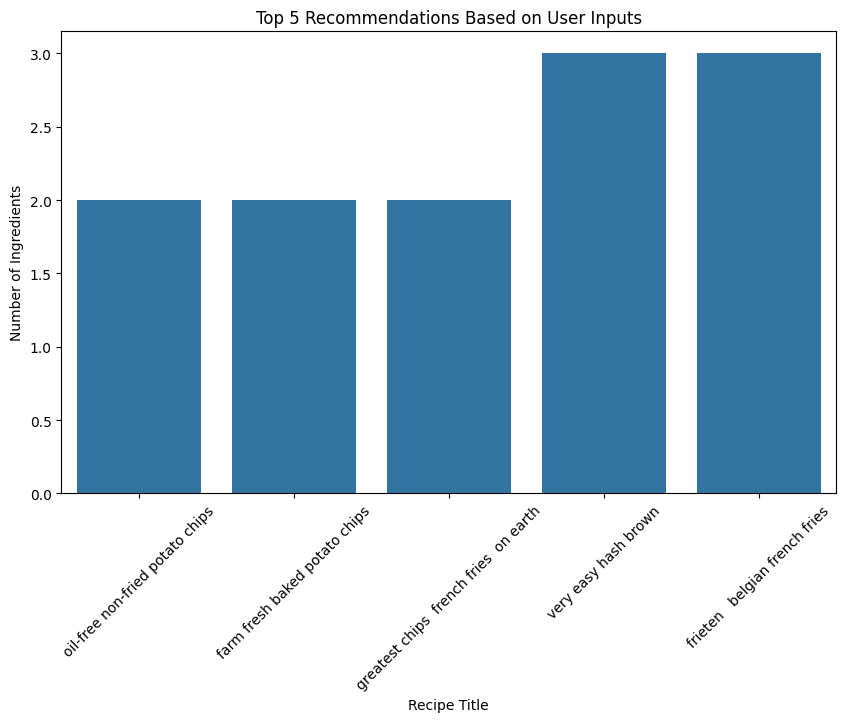

Top 5 Recommendations:
Title: oil-free non-fried potato chips
Ingredients: ["1 potato", "1 salt"]
Preparation Time: ["Peel and slice the potato.", "You don't have to slice it super thin, 1 mm or so is about right.", "You can do this quickly using a vegetable slice.", "Line the turntable of your microwave with kitchen parchment paper, and place the potato slices on it so that they don't overlap.", "Sprinkle lightly with salt, and microwave for about 5-6 minutes at 600 W. They will burn if you cook them too long, so keep an eye on them and adjust the time.", "If they look crispy, they are done.", "Variations: Besides salt, try seasoning the chips with aonori seaweed and salt; mentsuyu; Krazy Salt; garlic salt; soup stock granules; paprika or curry powder, karaage powder, etc.", "Try with other vegetables besides potatoes too."]

_______________________________________

Title: farm fresh baked potato chips
Ingredients: ['potato', 'salt']
Preparation Time: ['preheat oven to 300', 'oil 2 la

In [16]:
# Top 5 Recommendations Based on User Inputs
import matplotlib.pyplot as plt
import seaborn as sns
top_recommendations = recommended_recipes.head(5)

# Plotting the top 5 recommendations
plt.figure(figsize=(10, 6))
sns.barplot(x='title', y='ingredient_count', data=top_recommendations)
plt.title('Top 5 Recommendations Based on User Inputs')
plt.xlabel('Recipe Title')
plt.ylabel('Number of Ingredients')
plt.xticks(rotation=45)
plt.show()

# Displaying key ingredients and preparation times
print("Top 5 Recommendations:")
for idx, recipe in top_recommendations.iterrows():
    print(f"Title: {recipe['title']}")
    print(f"Ingredients: {recipe['ingredients']}")
    print(f"Preparation Time: {recipe['directions']}\n")
    print("_______________________________________\n")